<a href="https://colab.research.google.com/github/Daseinintheworld/seq2seq-transformer-buddhist-lexicon-inspired/blob/main/buddhist_lexicon_inspired_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Buddhist-Lexicon-Inspired-Seq2Seq-Phonetic-Reconstruction-of-Sanskrit Syllables in Hanzi using encoder decoder RNNs

In this notebook we'll be exploring the process used by the  great translators of the Buddhist lexicon- Zhi Qian (支謙, 3rd c.), Shi Daoan (釋道安, 312–385 CE), Zhu Fahu (竺法護, also known as Dharmarakṣa, 3rd–4th c.),Xuan Zang (玄奘, 602–664 CE, also Xuanzang the pilgrim), Bukong (不空, 705–774 CE, Amoghavajra in Sanskrit), Zhendi (真諦, 499–569 CE, Paramārtha in Sanskrit) ,Kumarajiva (鳩摩羅什, 344–413 CE, one of the greatest translators)

The modelling pipeline aims to replicate the translation forum conducted in the imperial courts and the likes of which were rigorously formalised since the times of Dao’an 道安. As described in scholarly texts like translation of T 1543 Abhidharma-jñānaprasthāna-śāstra in 383 AD in Chang’an 長安.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras as keras
import tensorflow_text as tf_text
from tf_keras.layers.experimental import preprocessing
from tf_keras.layers.experimental.preprocessing import TextVectorization
import matplotlib.pyplot as plt
import unicodedata

In [ ]:
  # First let's get our data ready. For this task we'll be taking bilingual sanskrit&mandarin dictionaries from the
# Taishō canon vol 54 pertaining to miscellneous manuscripts. Particularly we'll be
# looking into the entries T2133-b & T2135 with a total of 2613 samples.
!wget https://storage.googleapis.com/buddhist-lexicon-inspired-seq2seq-transformer/unseasoned-data/all-data-hns/t2135-and-t2133b%20-%20Sheet1-2.csv

--2025-10-13 15:02:51--  https://storage.googleapis.com/buddhist-lexicon-inspired-seq2seq-transformer/unseasoned-data/all-data-hns/t2135-and-t2133b%20-%20Sheet1-2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95217 (93K) [text/csv]
Saving to: ‘t2135-and-t2133b - Sheet1-2.csv’

t2135-and-t2133b -  100%[===================>]  92.99K  --.-KB/s    in 0.001s  

2025-10-13 15:02:52 (173 MB/s) - ‘t2135-and-t2133b - Sheet1-2.csv’ saved [95217/95217]



In [ ]:
all_data_unprocessed = pd.read_csv("t2135-and-t2133b - Sheet1-2.csv")
all_data_unprocessed

,hanzi,siddham
0,泥𭌯,𑖟𑖸𑖪
1,素羅,𑖀𑖭𑖲𑖨
2,摩拏史也(二合),𑖦𑖡𑖲𑖬𑖿𑖧
3,娜羅,𑖡𑖨
4,誐儞難,𑖐𑖡𑖰𑖜𑖽
...,...,...
2608,阿哦車,𑖁𑖐𑖓𑖿𑖔
2609,哦車,𑖐𑖓𑖿𑖔
2610,韈嚩蘇佉,𑖪𑖯𑖨𑖿𑖝𑖯-𑖭𑖲𑖏
2611,率都沙,𑖝𑖲𑖬𑖿𑖘


In [ ]:
# Let's shuffle our dataset prior to preprocessing.
all_data_shuffled = all_data_unprocessed.sample(frac = 1, random_state = 24)
all_data_shuffled

,hanzi,siddham
964,係縛哆,𑖮𑖸𑖪𑖝
2172,也他(引),𑖧𑖞𑖯
970,藥乞叉,𑖧𑖎𑖿𑖬
1011,折羅麼折微迦,𑖓𑖨𑖦𑖓𑖤𑖰𑖎
630,路拏,𑖩𑖺𑖜
...,...,...
2193,乞叉(二合)摩,𑖎𑖿𑖬𑖦𑖯
343,係瑟姹(二合)麼,𑖮𑖸𑖬𑖿𑖘𑖦
2240,播摩,𑖢𑖯𑖦𑖡𑖿
899,計捨羅,𑖎𑖸𑖭𑖨


In [ ]:
start_token = "<START>"
end_token = "<END>"

In [ ]:
hanzi = all_data_shuffled["hanzi"].apply(lambda x: ' '.join(x))
siddham = all_data_shuffled["siddham"].apply(lambda x: ' '.join(x))
siddham_train = siddham[:2091]
siddham_valid = siddham[2091:2352]
siddham_test = siddham[2352:2613]
hanzi_train = hanzi[:2091]
hanzi_valid = hanzi[2091:2352]
hanzi_test = hanzi[2352:2613]

In [ ]:
siddham_train

,siddham
964,𑖮 𑖸 𑖪 𑖝
2172,𑖧 𑖞 𑖯
970,𑖧 𑖎 𑖿 𑖬
1011,𑖓 𑖨 𑖦 𑖓 𑖤 𑖰 𑖎
630,𑖩 𑖺 𑖜
...,...
65,𑖦 𑖨 𑖿 𑖦
1689,𑖄 𑖝 𑖿 𑖭 𑖯 𑖮
2471,𑖭 𑖿 𑖝 𑖺 𑖎
2077,𑖭 𑖰 𑖟 𑖿 𑖠 𑖦 𑖿


In [ ]:
hanzi_train[:10]

,hanzi
964,係 縛 哆
2172,也 他 ( 引 )
970,藥 乞 叉
1011,折 羅 麼 折 微 迦
630,路 拏
1886,鉢 吒 素 怛 覽 ( 二 合 )
164,嚩 ( 無 可 反 ) 拏
1497,鉢 羅 ( 二 合 ) 惹 拏 ( 二 合 ) ( 引 )
656,矩 麼 羅
1913,縛 怛 縛 ( 二 合 ) 曩


In [ ]:
import tensorflow as tf
import tensorflow_text as tf_text

def text_normalizer(seq):
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*四[ ]*十[ ]*二[ ]*合[ ]*[)）]", "<SISHIERHE>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*三[ ]*合[ ]*[)）]", "<SANHE>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*二[ ]*合[ ]*[)）]", "<ERHE>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*引[ ]*[)）]", "<YIN>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*去[ ]*[)）]", "<QU>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*平[ ]*[)）]", "<PING>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*上[ ]*[)）]", "<SHANG>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*入[ ]*[)）]", "<RU>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*重[ ]*[)）]", "<ZHONG>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*又[ ]*云[ ]*[)）]", "<YOUYIN>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*反[ ]*[)）]", "<FAN>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*合[ ]*[)）]", "<HE>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*重[ ]*引[ ]*[)）]", "<ZHONGYIN>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*又[ ]*曰[ ]*[)）]", "<YOUYUE>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*若[ ]*[)）]", "<RUO>")
    seq = tf.strings.regex_replace(seq, r"[(（][ ]*此[ ]*云[ ]*[)）]", "<CIYUN>")

    seq = tf.strings.regex_replace(seq, r"(<\s*[A-Z]+\s*>)", r" \1 ")
    seq = tf.strings.regex_replace(seq, r"<\s*([A-Z]+)\s*>", r"<\1>")

    seq = tf.strings.regex_replace(seq, r"[a-z0-9ㄅ-ㄩ‧\-\?\!\=\+\_]", " ")

    seq = tf.strings.regex_replace(seq, r"[^𑖀-𑗿一-龯A-Z<>\s]", " ")


    seq = tf.strings.regex_replace(seq, r"\s+", " ")
    seq = tf.strings.strip(seq)

    seq = tf_text.normalize_utf8(seq, "NFC")

    seq = tf.strings.join(["<START>", seq, "<END>"], separator=" ")

    return seq


In [ ]:
text_normalizer("鉢 吒 素 怛 覽 ( 二 合 )")

<tf.Tensor: shape=(), dtype=string, numpy=b'<START> \xe9\x89\xa2 \xe5\x90\x92 \xe7\xb4\xa0 \xe6\x80\x9b \xe8\xa6\xbd <ERHE> <END>'>

In [ ]:
s_max_vocab_length = 2000

siddham_text_processor = TextVectorization(
    max_tokens = s_max_vocab_length,
    standardize = text_normalizer,
    split = "whitespace",
    output_mode = "int"
)

siddham_text_processor.adapt(siddham_train)

In [ ]:
siddham_text_processor(["𑖮 𑖸 𑖪 𑖝"])

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[ 2, 25, 20, 11,  7,  3]])>

In [ ]:
h_max_vocab_length = 2000
hanzi_text_processor = TextVectorization(
max_tokens = h_max_vocab_length,
standardize = text_normalizer,
split="whitespace",
output_mode="int")

hanzi_text_processor.adapt(hanzi_train)

In [ ]:
hanzi_text_processor(["也 他 ( 引 )"])

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 2, 10, 50,  5,  3]])>

In [ ]:
# get the top 10 most common tokens in our vocabulary
siddham_text_processor.get_vocabulary()[-10:], hanzi_text_processor.get_vocabulary()[-10:]

([np.str_('𑖣'),
  np.str_('𑖂'),
  np.str_('𑖾'),
  np.str_('𑖛'),
  np.str_('𑖻'),
  np.str_('𑖆'),
  np.str_('𑖅'),
  np.str_('𑖌'),
  np.str_('𑖈'),
  np.str_('𑖃')],
 [np.str_('先'),
  np.str_('億'),
  np.str_('傍'),
  np.str_('借'),
  np.str_('候'),
  np.str_('佷'),
  np.str_('作'),
  np.str_('但'),
  np.str_('二'),
  np.str_('七')])

In [ ]:
siddham_sequences = siddham_text_processor(siddham_train)
hanzi_sequences = hanzi_text_processor(hanzi_train)
siddham_val_seq = siddham_text_processor(siddham_valid)
hanzi_val_seq = hanzi_text_processor(hanzi_valid)
siddham_test_seq = siddham_text_processor(siddham_test)
hanzi_test_seq = hanzi_text_processor(hanzi_test)

In [ ]:
hanzi_in = hanzi_sequences[:,:-1]
hanzi_out = hanzi_sequences[:,1:]

hanzi_in_val = hanzi_val_seq[:,:-1]
hanzi_out_val = hanzi_val_seq[:,1:]

hanzi_in_test = hanzi_test_seq[:,:-1]
hanzi_out_test = hanzi_test_seq[:,1:]

In [ ]:
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((
    (siddham_sequences, hanzi_in),
    hanzi_out
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    (siddham_val_seq, hanzi_in_val),
    hanzi_out_val
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    (siddham_test_seq, hanzi_in_test),
    hanzi_out_test
))

train_ds = (
    train_dataset
    .padded_batch(BATCH_SIZE,
                  padded_shapes = (([None], [None]), [None]),
                  padding_values=((tf.constant(0, dtype=tf.int64),
                                   tf.constant(0, dtype=tf.int64)),
                                   tf.constant(0, dtype=tf.int64)))
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_dataset
    .padded_batch(BATCH_SIZE,
                  padded_shapes = (([None], [None]), [None]),
                  padding_values=((tf.constant(0, dtype=tf.int64),
                                   tf.constant(0, dtype=tf.int64)),
                                   tf.constant(0, dtype=tf.int64)))
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_dataset
    .padded_batch(BATCH_SIZE,
                  padded_shapes = (([None], [None]), [None]),
                  padding_values=((tf.constant(0, dtype=tf.int64),
                                   tf.constant(0, dtype=tf.int64)),
                                   tf.constant(0, dtype=tf.int64)))
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# Let's instantiate an encoder using Keras's functional API.

In [ ]:
class Encoder(keras.layers.Layer):
  def __init__(self, text_processor, enc_units):
    super(Encoder, self).__init__()
    self.vocab_size = text_processor.vocabulary_size()

    # The embedding layer converts tokens to vectors
    self.embedding = keras.layers.Embedding(input_dim = self.vocab_size,
                                            output_dim = enc_units,
                                            mask_zero = True)

    # The RNN vector processes those vectors sequentially
    self.rnn = keras.layers.Bidirectional(
        merge_mode = 'sum',
        layer = keras.layers.GRU(enc_units,
                                 # Return the sequence and state
                                 return_sequences = True,
                                 return_state = True,
                                 recurrent_initializer = "glorot_uniform")
    )

  def call(self, x):
    # 2. The embedding layer looks up the embedding vector from each token
    x = self.embedding(x)

    # 3. The RNN discards the encoder outputs and instead returns the
    # hidden states from each time step along with the final encoder hidden state
    # at the last time step

    enc_hidden_states, fwd_enc_state, bwd_enc_state = self.rnn(x)
    final_enc_state = fwd_enc_state + bwd_enc_state

    # 4. Returns the encoder's hidden states at each time step
    return enc_hidden_states, final_enc_state


In [ ]:
class LuongAttention(keras.layers.Layer):
  def __init__(self, dense_units):
    super().__init__()
    self.Wa = keras.layers.Dense(dense_units, use_bias = False)
    self.Wc = keras.layers.Dense(dense_units, activation = "tanh")

  def call(self, dec_hidden_states, enc_hidden_states):
    """
    dec_hidden_states.shape = (batch, dec_seq_length, dec_hidden_dims)
    enc_hidden_states.shape = (batch, enc_seq_length, enc_hidden_units)
    """
    # Get the projected encoder states in order to map it to a new embedding
    # space to enable better comparison with the decoder hidden state

    projected_enc_state = self.Wa(enc_hidden_states) # returns batched tensors of shape (batch, enc_seq_length, dense_units)
    gen_product_score = tf.matmul(projected_enc_state, dec_hidden_states, transpose_b = True) # returns batched tensors of shape (batch, enc_seq_length, dec_seq_length)
    attn_weights = tf.nn.softmax(gen_product_score, axis = 1) # returns batched tensors of shape (batch, enc_seq_length, dec_seq_length)

    # Cache the attention weights for time-step every time the call method is
    # instantiated for plotting cross-attention matrix later
    self.last_attn_weights = attn_weights

    # Get the context vector
    context_vector = tf.matmul(attn_weights, enc_hidden_states, transpose_a = True)
    # and returns a tensor of shape (batch, dec_seq_length, enc_hidden_dims)

    # Get the attention hidden state
    attn_hidden_states = self.Wc(tf.concat([context_vector, dec_hidden_states], axis = -1)) # returns batched tensors of shape (batch, dec_seq_length, dense_units)
    # concatenates the context vector with the decoder hidden state at each time
    # step to preserve information from both and returns the final attention state
    # used to compute the output at that time step.

    return attn_hidden_states


In [ ]:
class LuongStepAttention(keras.layers.Layer):
  def __init__(self, dense_units):
    super().__init__()
    self.Wa = keras.layers.Dense(dense_units, use_bias = False)
    self.Wc = keras.layers.Dense(dense_units, activation = "tanh")

  def call(self, dec_hidden_state, enc_hidden_states):

    projected_enc_state = self.Wa(enc_hidden_states)
    dec_hidden_state = tf.expand_dims(dec_hidden_state, axis = 1)
    gen_product_score = tf.matmul(projected_enc_state, dec_hidden_state, transpose_b = True)
    attn_weights = tf.nn.softmax(tf.squeeze(gen_product_score, axis = -1), axis = 1)

    self.last_attn_weight = attn_weights

    context_vector = tf.reduce_sum(tf.expand_dims(attn_weights, axis = -1) * enc_hidden_states, axis = 1)

    attn_hidden_state = self.Wc(tf.concat([context_vector, tf.squeeze(dec_hidden_state, axis = 1)], axis = -1))

    return attn_hidden_state

In [ ]:
class Decoder(keras.layers.Layer):
  def __init__(self,
               text_processor,
               dec_units):
    super(Decoder, self).__init__()

    self.vocab_size = text_processor.vocabulary_size()
    self.vocab = text_processor.get_vocabulary()
    self.word_to_id = keras.layers.StringLookup(vocabulary= self.vocab, mask_token='', oov_token='[UNK]')
    self.id_to_word = keras.layers.StringLookup(vocabulary= self.vocab, invert=True, mask_token='', oov_token='[UNK]')
    self.start_token = self.word_to_id(tf.constant(["<START>"]))[0]
    self.end_token = self.word_to_id(tf.constant(["<END>"]))[0]
    self.embedding = keras.layers.Embedding(input_dim = self.vocab_size,
                                            output_dim = dec_units,
                                            mask_zero = True)

    self.rnn = keras.layers.GRU(units = dec_units,
                                return_sequences = True,
                                return_state = True,
                                recurrent_initializer = "glorot_uniform")

    self.attention = LuongAttention(dec_units)
    self.step_attention = LuongStepAttention(dec_units)

    self.Ws = keras.layers.Dense(self.vocab_size, activation = "softmax")

  # For training
  def call(self,
           enc_states, x,
           state,
           return_state = False):

    x = self.embedding(x)

    x, dec_final_state = self.rnn(x, initial_state = state)

    x = self.attention(dec_hidden_states = x, enc_hidden_states = enc_states)
    self.last_attention_weights = self.attention.last_attn_weights

    logits = self.Ws(x)

    if return_state:
      return logits, dec_final_state
    else:
      return logits

  # For inference
  def get_initial_state(self, enc_states, enc_final_state):
    batch_size = tf.shape(enc_states)[0]
    start_tokens = tf.fill([batch_size, 1], tf.cast(self.start_token, tf.int64))
    done = tf.zeros([batch_size, 1], dtype = tf.bool)

    return start_tokens, done, enc_final_state

  def get_next_token(self, enc_states, next_token, done, state, temperature = 0.0):

    x = self.embedding(next_token)
    x, state = self.rnn(x, initial_state = state)

    x = self.step_attention(dec_hidden_state = state, enc_hidden_states = enc_states)
    self.last_attn_weight = self.step_attention.last_attn_weight

    logits = self.Ws(x)

    if len(logits.shape) == 3:
      logits = tf.squeeze(logits, axis = 1)


    if temperature == 0.0:
      next_token = tf.argmax(logits, axis = -1, output_type = tf.int64)
      next_token = tf.expand_dims(next_token, axis = -1)
    else:
      samples = tf.random.categorical(logits / temperature, num_samples = 1)
      next_token = tf.cast(samples, tf.int64)

    # If a sequence produces an `end_token` set it as `done`
    done = done | (next_token == tf.cast(self.end_token, next_token.dtype))
    # Once a sequence si done it only produces 0-padding
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)


    return next_token, done, state

  def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis = -1, separator='')
    result = tf.strings.regex_replace(result, r"\<START\>", "")
    result = tf.strings.regex_replace(result, r"\<END\>", "")
    return result

In [ ]:
class Translator(keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               enc_text_processor,
               dec_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(enc_text_processor, units)
    decoder = Decoder(dec_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    enc_input_seq, dec_input_seq = inputs
    enc_states, enc_final_state = self.encoder(enc_input_seq)
    logits = self.decoder(enc_states, dec_input_seq, state = enc_final_state, return_state = False)

    return logits


In [ ]:
@Translator.add_method
def translate(self,
              enc_input_seq,
              text_processor = siddham_text_processor,
              *,
              max_length=11,
              temperature=0.0,
              repeat_threshold=2):

    self.text_processor = text_processor

    if isinstance(enc_input_seq, str):
        enc_input_seq = tf.constant([enc_input_seq])
    elif isinstance(enc_input_seq, list) and isinstance(enc_input_seq[0], str):
        enc_input_seq = tf.constant(enc_input_seq)
    elif tf.is_tensor(enc_input_seq) and enc_input_seq.dtype == tf.string:
        pass
    elif isinstance(enc_input_seq, pd.Series):
      # Convert Pandas Series to tf.constant of strings
      enc_input_seq = tf.constant(enc_input_seq.astype(str).tolist())
    else:
        raise TypeError(
            f"The encoder input sequence must be a string, list[str], or tf.string. "
            f"Got {type(enc_input_seq)} instead"
        )


    enc_input_seq = text_processor(enc_input_seq)
    enc_hidden_states, enc_final_state = self.encoder(enc_input_seq)
    state = enc_final_state

    tokens = []
    attn_weights = []
    next_token, done, dec_int_state = self.decoder.get_initial_state(enc_hidden_states, state)
    eos_id = tf.cast(self.decoder.end_token, next_token.dtype)

    last_token = tf.fill(tf.shape(next_token), tf.constant(-1, dtype=next_token.dtype))
    repeat_count = tf.zeros_like(next_token, dtype=tf.int32)

    for t in tf.range(max_length):
        next_token, done, state = self.decoder.get_next_token(
            enc_hidden_states, next_token, done, state, temperature
        )

        tokens.append(next_token)
        attn_weights.append(self.decoder.last_attn_weight)

        same_as_last = tf.equal(next_token, last_token)
        repeat_count = tf.where(same_as_last, repeat_count + 1, 1)
        last_token = next_token
        done = done | (repeat_count >= repeat_threshold)

        if tf.executing_eagerly():
            if tf.reduce_all(done).numpy():
                break
            if tf.reduce_all(tf.equal(next_token, eos_id)).numpy():
                break

    tokens = tf.concat(tokens, axis=-1)
    self.last_attn_weight = tf.concat(attn_weights, axis=1)

    result = self.decoder.tokens_to_text(tokens)
    return result


In [ ]:
def weighted_loss(y_true, y_pred, end_token, alpha):
  # Calculate the loss for each sequence in the batch.
  if not tf.is_tensor(end_token):
        end_token = tf.convert_to_tensor(end_token, dtype=y_true.dtype)
  else:
        end_token = tf.cast(end_token, y_true.dtype)

  loss_fxn = keras.losses.SparseCategoricalCrossentropy(
      from_logits = False, reduction = 'none'
  )
  loss = loss_fxn(y_true, y_pred)

  # Mask off the losses on padding.

  end_mask = tf.cast( y_true == end_token, loss.dtype)
  mask = tf.cast(y_true != 0, loss.dtype)
  weights=  mask + alpha * end_mask
  loss *= weights

  # Return the total.
  return tf.reduce_sum(loss)/tf.reduce_sum(weights)

In [ ]:
def masked_accuracy(y_true, y_pred):
  y_pred = tf.argmax(y_pred, axis = -1)
  y_pred = tf.cast(y_pred, y_true.dtype)

  match = tf.cast(y_true == y_pred, tf.float32)
  mask = tf.cast(y_true != 0, tf.float32)

  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
UNITS = 256
model = Translator(UNITS, siddham_text_processor, hanzi_text_processor)

logits = model((siddham_sequences, hanzi_in))
end_token = model.decoder.end_token

In [ ]:
loss_fxn = lambda y_true, y_pred: weighted_loss(y_true, y_pred, end_token = end_token, alpha = 1)
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
              loss = loss_fxn,
              metrics = [masked_accuracy])

In [ ]:
history = model.fit(train_ds.repeat(),
                    epochs = 200,
                    steps_per_epoch = len(train_ds),
                    validation_data = val_ds,
                    validation_steps = 9,
                    callbacks = keras.callbacks.EarlyStopping(patience = 10,
                                                              restore_best_weights = True))

Epoch 1/200
66/66 [==============================] - 24s 154ms/step - loss: 5.7498 - masked_accuracy: 0.1939 - val_loss: 4.3058 - val_masked_accuracy: 0.2046
Epoch 2/200
66/66 [==============================] - 1s 16ms/step - loss: 3.8499 - masked_accuracy: 0.2084 - val_loss: 3.6342 - val_masked_accuracy: 0.2046
Epoch 3/200
66/66 [==============================] - 1s 15ms/step - loss: 3.5993 - masked_accuracy: 0.2084 - val_loss: 3.5410 - val_masked_accuracy: 0.2046
Epoch 4/200
66/66 [==============================] - 1s 15ms/step - loss: 3.5151 - masked_accuracy: 0.2121 - val_loss: 3.4615 - val_masked_accuracy: 0.2243
Epoch 5/200
66/66 [==============================] - 1s 15ms/step - loss: 3.4407 - masked_accuracy: 0.2358 - val_loss: 3.4008 - val_masked_accuracy: 0.2448
Epoch 6/200
66/66 [==============================] - 1s 15ms/step - loss: 3.3854 - masked_accuracy: 0.2494 - val_loss: 3.3570 - val_masked_accuracy: 0.2668
Epoch 7/200
66/66 [==============================] - 1s 15ms/s

In [ ]:
model.evaluate(val_ds)

9/9 [==============================] - 0s 8ms/step - loss: 1.7689 - masked_accuracy: 0.6044


[1.7688673734664917, 0.6043828129768372]

In [ ]:
model.evaluate(test_ds)

9/9 [==============================] - 0s 7ms/step - loss: 1.9976 - masked_accuracy: 0.5750


[1.997637152671814, 0.5749640464782715]

In [ ]:
model.save_weights("model_1_weights.ckpt")

In [ ]:
UNITS = 512
model_2 = Translator(UNITS, siddham_text_processor, hanzi_text_processor)

logits = model_2((siddham_sequences, hanzi_in))
end_token = model_2.decoder.end_token

In [ ]:
loss_fxn_2 = lambda y_true, y_pred: weighted_loss(y_true, y_pred, end_token = end_token, alpha = 5)
model_2.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
                loss = loss_fxn_2,
                metrics = [masked_accuracy])

In [ ]:
history_2 = model_2.fit(train_ds.repeat(),
                        epochs = 200,
                        steps_per_epoch = len(train_ds),
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = [keras.callbacks.EarlyStopping(patience = 10,
                                                                   restore_best_weights = True)]
                        )

Epoch 1/200
66/66 [==============================] - 23s 153ms/step - loss: 4.1883 - masked_accuracy: 0.2024 - val_loss: 2.5343 - val_masked_accuracy: 0.2046
Epoch 2/200
66/66 [==============================] - 1s 18ms/step - loss: 2.3789 - masked_accuracy: 0.2084 - val_loss: 2.2664 - val_masked_accuracy: 0.2046
Epoch 3/200
66/66 [==============================] - 1s 16ms/step - loss: 2.2301 - masked_accuracy: 0.2135 - val_loss: 2.1530 - val_masked_accuracy: 0.2272
Epoch 4/200
66/66 [==============================] - 1s 16ms/step - loss: 2.1420 - masked_accuracy: 0.2327 - val_loss: 2.0912 - val_masked_accuracy: 0.2426
Epoch 5/200
66/66 [==============================] - 1s 17ms/step - loss: 2.0829 - masked_accuracy: 0.2441 - val_loss: 2.0436 - val_masked_accuracy: 0.2630
Epoch 6/200
66/66 [==============================] - 1s 16ms/step - loss: 2.0350 - masked_accuracy: 0.2561 - val_loss: 2.0065 - val_masked_accuracy: 0.2669
Epoch 7/200
66/66 [==============================] - 1s 16ms/s

In [ ]:
model_2.save_weights("model_2_weights.ckpt")


In [ ]:
model_2.evaluate(val_ds)

9/9 [==============================] - 0s 9ms/step - loss: 1.0614 - masked_accuracy: 0.6106


[1.061368703842163, 0.610637366771698]

In [ ]:
model_2.evaluate(test_ds)

9/9 [==============================] - 0s 9ms/step - loss: 1.2658 - masked_accuracy: 0.5800


[1.2657839059829712, 0.5799930095672607]

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["masked_accuracy"]
  val_accuracy = history.history["val_masked_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "validation_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()


  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "validation_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


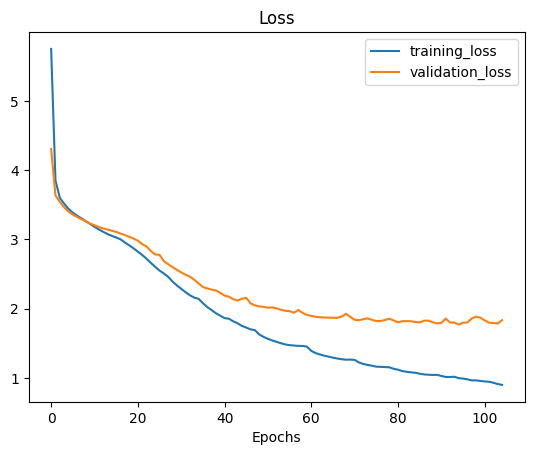

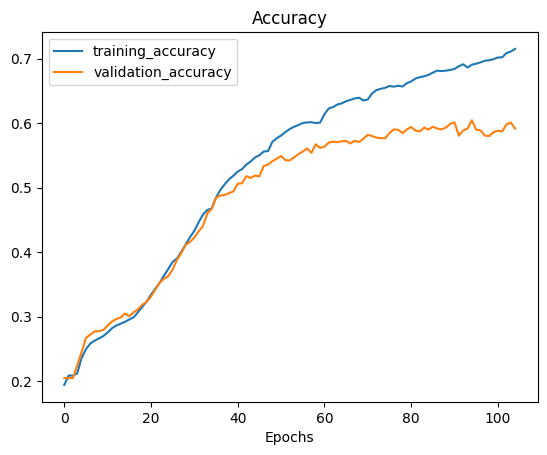

In [ ]:
plot_loss_curves(history)

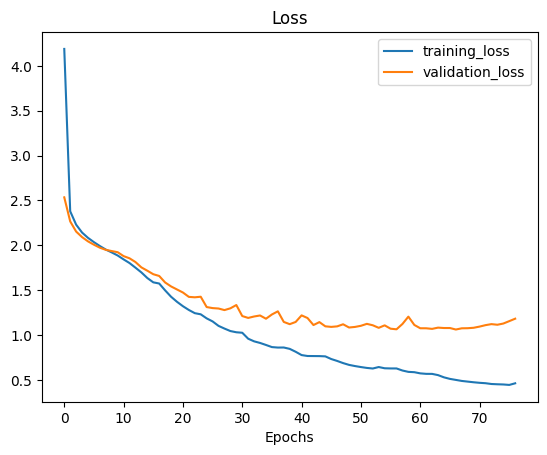

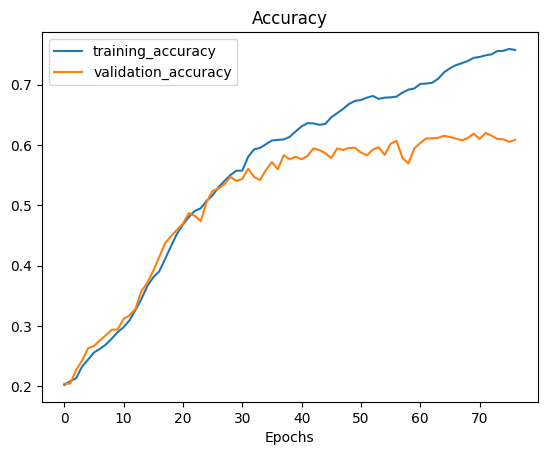

In [ ]:
plot_loss_curves(history_2)

In [ ]:
!gcloud auth login
!gcloud config set project my-gcp-project-id

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=QhYOcuDPPLbheaMe9UMqNdg2cs9bLz&prompt=consent&token_usage=remote&access_type=offline&code_challenge=3tUOVXvH53c0g0HyMYiOwTs0Ht6ZroooDIJEGT1iJCU&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AVGzR1ADrqwXSp2tXQvMccZJVYHpAIKv-Lr7cls33Awy_RwHmtUuliSP3yEupMi42b2gzA

You are now logged in as [humaabiakanta@gmail.com].
Your current projec

In [ ]:
!gsutil cp model_1_weights.ckpt* gs://buddhist-lexicon-inspired-seq2seq-transformer/models/model_1_weights.ckpt

Copying file://model_1_weights.ckpt.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://model_1_weights.ckpt.index [Content-Type=application/octet-stream]...
- [2 files][ 19.9 MiB/ 19.9 MiB]                                                
Operation completed over 2 objects/19.9 MiB.                                     


In [ ]:
!gsutil cp model_2_weights.ckpt* gs://buddhist-lexicon-inspired-seq2seq-transformer/models/model_2_weights.ckpt

Copying file://model_2_weights.ckpt.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://model_2_weights.ckpt.index [Content-Type=application/octet-stream]...
\
Operation completed over 2 objects/72.8 MiB.                                     


## Custom Evaluation

In [ ]:
pip install aksharamukha

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 44.4 MB/s eta 0:00:00
  Created wheel for jaconv: filename=jaconv-0.4.0-py3-none-any.whl size=18228 sha256=52ae2204fced83f1f429fba9ed5679f162c4a1afc65bc5199260d98f628ec788
  Stored in directory: /root/.cache/pip/wheels/c9/97/53/1f827ebf916b899520ce663227497206525c432be72cc29265
Successfully built jaconv


In [ ]:
from aksharamukha import transliterate
def convert_to_ipa(input_seq, input_script = "Siddham", output_script = "IPA"):
  """
  Takes a python list and transliterates it as per IAST conventions
  """
  results = []
  for c in input_seq:
    result = transliterate.process(input_script, output_script, c)
    results.append(result)
  return results

In [ ]:
import re
def clean_text(text):
  """
  Normalizes prosodic features for computing segmental similiarities with Siddham IAST
  """
  text = re.sub(r"\[[^\]]*\]", "", text)
  text = re.sub(r"[HX]", "", text)
  text = re.sub(r"\s+", "", text).strip()
  return text

In [ ]:
siddham_list = siddham_test.tolist()
siddham_list

['𑖕 𑖯 𑖡 𑖯 𑖝 𑖰',
 '𑖐 𑖨 𑖟',
 '𑖕 𑖯 𑖝 𑖰',
 '𑖟 𑖴 𑖬 𑖿 𑖘',
 '𑖦 𑖫 𑖿 𑖧 𑖨 𑖝 𑖿 𑖝 𑖿 𑖨 𑖰',
 '𑖪 𑖰 𑖫 𑖲 𑖪 𑖭 𑖡 𑖰 𑖝 𑖲',
 '𑖁 𑖣 𑖎',
 '𑖥 𑖐',
 '𑖭 𑖿 𑖎 𑖟 𑖪',
 '𑖭 𑖿 𑖎 𑖡 𑖿 𑖠',
 '𑖢 𑖿 𑖨 𑖓 𑖜 𑖿 𑖚',
 '𑖀 𑖦 𑖒 𑖿 𑖐 𑖩 𑖿 𑖧',
 '𑖪 𑖯 𑖢 𑖱',
 '𑖧 𑖯 𑖓 𑖿 𑖗 𑖯',
 '𑖪 𑖰 𑖨 𑖲',
 '𑖪 𑖨',
 '𑖓 𑖽 𑖢',
 '𑖠 𑖾 𑖪',
 '𑖢 𑖘',
 '𑖟 𑖟 𑖰 𑖦',
 '𑖢 𑖿 𑖨 𑖥 𑖯',
 '𑖭 𑖲 𑖐 𑖡 𑖿 𑖠',
 '𑖧 𑖬 𑖿 𑖘 𑖰',
 '𑖨 𑖝 𑖿 𑖡',
 '𑖪 𑖭 𑖿 𑖝 𑖿 𑖨',
 '𑖝 𑖿 𑖨 𑖧',
 '𑖐 𑖴 𑖠 𑖿 𑖨',
 '𑖄 𑖟 𑖎',
 '𑖫 𑖯 𑖎 𑖦',
 '𑖦 𑖨 𑖐 𑖫 𑖰 𑖨',
 '𑖀 𑖥 𑖿 𑖧 𑖡 𑖿 𑖝 𑖨',
 '𑖕 𑖿 𑖗 𑖯 𑖡',
 '𑖀 𑖟 𑖰',
 '𑖡 𑖰 𑖨 𑖿 𑖪 𑖯 𑖜',
 '𑖀 𑖬 𑖿 𑖘',
 '𑖢 𑖗 𑖿 𑖓',
 '𑖧 𑖎 𑖿 𑖬',
 '𑖎 𑖘 𑖰',
 '𑖢 𑖩 𑖫',
 '𑖎 𑖘 𑖯 𑖮',
 '𑖓 𑖰 𑖝 𑖿 𑖝 𑖢 𑖰 𑖜',
 '𑖎 𑖡 𑖱 𑖧 𑖭 𑖥 𑖿 𑖨 𑖯 𑖝 𑖴',
 '𑖭 𑖿 𑖪 𑖨',
 '𑖟 𑖿 𑖠 𑖟 𑖫',
 '𑖭 𑖿 𑖞 𑖯 𑖡',
 '𑖐 𑖴 𑖕 𑖡',
 '𑖎 𑖡 𑖿 𑖟 𑖲',
 '𑖭 𑖭 𑖿 𑖞 𑖰 𑖝',
 '𑖊 𑖎 𑖸 𑖜 𑖫',
 '𑖢 𑖴 𑖞 𑖎 𑖿',
 '𑖃 𑖫',
 '𑖭 𑖳 𑖝 𑖿 𑖨',
 '𑖢 𑖯 𑖨 𑖫 𑖿 𑖪',
 '𑖎 𑖨 𑖸 𑖡',
 '𑖬 𑖚 𑖿',
 '𑖢 𑖸 𑖘',
 '𑖓 𑖲 𑖜',
 '𑖠 𑖨 𑖿 𑖦 𑖿 𑖦 𑖎 𑖲 𑖨 𑖰',
 '𑖭 𑖿 𑖎 𑖨',
 '𑖨 𑖕',
 '𑖎 𑖲 𑖭 𑖲 𑖦 𑖿 𑖥 𑖪 𑖨 𑖿 𑖜',
 '𑖥 𑖎 𑖿 𑖝 𑖰 𑖫 𑖩 𑖰',
 '𑖢 𑖜',
 '𑖪 𑖜 𑖰 𑖕',
 '𑖀 𑖟 𑖿 𑖧',
 '𑖪 𑖓 𑖎 𑖲 𑖨 𑖰',
 '𑖕 𑖦 𑖯 𑖝 𑖿 𑖨',
 '𑖦 𑖴 𑖎 𑖿 𑖬',
 '𑖪 𑖰 𑖢 𑖿 𑖨 𑖎 𑖿 𑖨 𑖡',
 '𑖧 𑖟 𑖰',
 '𑖧 𑖲 𑖝 𑖿 𑖪',
 '𑖫 𑖩 𑖯 

In [ ]:
siddham_iast = convert_to_ipa(siddham_list)
cleaned_siddham_ipa = []
for text in siddham_iast:
  cleaned_text = clean_text(text)
  cleaned_siddham_ipa.append(cleaned_text)
cleaned_siddham_ipa

['d͡ʒəɑːn̪əɑːt̪əɪ',
 'gəɾəd̪ə',
 'd͡ʒəɑːt̪əɪ',
 'd̪əɾɨʂəʈə',
 'məʃəjəɾət̪ət̪əɾəɪ',
 'ʋəɪʃəuʋəs̪ən̪əɪt̪əu',
 'ɑːpʰəkə',
 'bʰəgə',
 's̪əkəd̪əʋə',
 's̪əkən̪əd̪ʰə',
 'pəɾət͡ʃəɳəɖə',
 'əməŋəgələjə',
 'ʋəɑːpəiː',
 'jəɑːt͡ʃəɲəɑː',
 'ʋəɪɾəu',
 'ʋəɾə',
 't͡ʃə̃pə',
 'd̪ʰəh̆ʋə',
 'pəʈə',
 'd̪əd̪əɪmə',
 'pəɾəbʰəɑː',
 's̪əugən̪əd̪ʰə',
 'jəʂəʈəɪ',
 'ɾət̪ən̪ə',
 'ʋəs̪ət̪əɾə',
 't̪əɾəjə',
 'gəɾɨd̪ʰəɾə',
 'ud̪əkə',
 'ʃəɑːkəmə',
 'məɾəgəʃəɪɾə',
 'əbʰəjən̪ət̪əɾə',
 'd͡ʒəɲəɑːn̪ə',
 'əd̪əɪ',
 'n̪əɪɾəʋəɑːɳə',
 'əʂəʈə',
 'pəɲət͡ʃə',
 'jəkəʂə',
 'kəʈəɪ',
 'pələʃə',
 'kəʈəɑːɦə',
 't͡ʃəɪt̪ət̪əpəɪɳə',
 'kən̪əiːjəs̪əbʰəɾəɑːt̪əɾɨ',
 's̪əʋəɾə',
 'd̪əd̪ʰəd̪əʃə',
 's̪ət̪ʰəɑːn̪ə',
 'gəɾɨd͡ʒən̪ə',
 'kən̪əd̪əu',
 's̪əs̪ət̪ʰəɪt̪ə',
 'eːkəeːɳəʃə',
 'pəɾɨt̪ʰəkə',
 'iːʃə',
 's̪əuːt̪əɾə',
 'pəɑːɾəʃəʋə',
 'kəɾəeːn̪ə',
 'ʂəɖə',
 'pəeːʈə',
 't͡ʃəuɳə',
 'd̪ʰəɾəməməkəuɾəɪ',
 's̪əkəɾə',
 'ɾəd͡ʒə',
 'kəus̪əuməbʰəʋəɾəɳə',
 'bʰəkət̪əɪʃələɪ',
 'pəɳə',
 'ʋəɳəɪd͡ʒə',
 'əd̪əjə',
 'ʋət͡ʃəkəuɾəɪ',
 'd͡ʒəməɑːt̪əɾə',
 'məɾɨkəʂə',
 'ʋəɪpəɾəkə

In [ ]:
hanzi_to_tang = {
    '三': 'san',
    '乞': 'kʰit̚',
    '他': 'tʰa',
    '使': 'ɕiɪ',
    '勢': 'ɕiei',
    '博': 'pɑk̚',
    '參': 'tsʰam',
    '吉': 'kit̚',
    '命': 'mjeng',
    '咜': 'tʰa',
    '壹': 'ʔit̚',
    '奇': 'gje',
    '女': 'nyo',
    '宜': 'ŋi',
    '尾': 'mjɪ',
    '弗': 'pʰut̚',
    '弭': 'miɪ',
    '徒': 'du',
    '必': 'pit̚',
    '惡': 'ʔɑk̚',
    '擬': 'ŋiɪ',
    '梨': 'li',
    '比': 'piɪ',
    '毘': 'bi',
    '沒': 'mut̚',
    '注': 'tɕju',
    '物': 'mjut̚',
    '獻': 'hjen',
    '理': 'liɪ',
    '畢': 'pit̚',
    '盎': 'ʔaŋ',
    '睺': 'ɣu',
    '禮': 'lie',
    '至': 'tɕi',
    '訖': 'kʰit̚',
    '賓': 'pin',
    '遇': 'ŋjo',
    '都': 'to',
    '里': 'li',
    '鉢': 'puət̚',
    '銘': 'mjeng',
    '閉': 'pjet̚',
    '陛': 'bje',
    '陳': 'drin',
    '頗': 'pʰa',
    '齒': 'tʂʰiɪ',
    '也': 'ja',
    '以': 'jiɪ',
    '但': 'dan',
    '佗': 'tʰa',
    '例': 'liei',
    '儞': 'niɪ',
    '先': 'sen',
    '劍': 'kɛm',
    '卑': 'pje',
    '吐': 'tʰu',
    '吠': 'bʰoi',
    '呼': 'xu',
    '哩': 'li',
    '嚴': 'ŋiam',
    '囉': 'la',
    '地': 'di',
    '壇': 'dan',
    '婆': 'ba',
    '嬌': 'kieu',
    '孕': 'jwng',
    '室': 'ʂit̚',
    '寧': 'neng',
    '寫': 'sia',
    '弟': 'dei',
    '憾': 'ɣam',
    '折': 'tɕiet̚',
    '捨': 'ɕia',
    '措': 'tsʰa',
    '提': 'dej',
    '揭': 'kjet̚',
    '撥': 'puət̚',
    '攘': 'ɲiang',
    '攬': 'lam',
    '於': 'ʔuo',
    '曩': 'nang',
    '曲': 'kʰjuk̚',
    '木': 'muk̚',
    '析': 'sek̚',
    '枳': 'tɕiɪ',
    '柁': 'tʰa',
    '柘': 'tɕia',
    '栖': 'sei',
    '棄': 'kʰei',
    '每': 'moi',
    '沙': 'ɕa',
    '涅': 'njet̚',
    '滯': 'drej',
    '滿': 'mwan',
    '玉': 'ŋiuk̚',
    '瑟': 'sit̚',
    '畒': 'mju',
    '盆': 'bun',
    '相': 'sjang',
    '禁': 'kim',
    '禪': 'ɕjen',
    '禰': 'nʲie',
    '竭': 'kjet̚',
    '縒': 'tsʰa',
    '罽': 'kjei',
    '耄': 'mau',
    '能': 'nəŋ',
    '臡': 'ni',
    '茗': 'mjeng',
    '莾': 'maŋ',
    '薜': 'pjek̚',
    '藍': 'lam',
    '補': 'puo',
    '親': 'tɕʰin',
    '訥': 'nʌt̚',
    '請': 'tɕʰjeng',
    '諾': 'nak̚',
    '賀': 'ɣa',
    '辟': 'pjek̚',
    '達': 'dat̚',
    '避': 'bjiek̚',
    '那': 'na',
    '重': 'dʑuŋ',
    '鏟': 'tɕʰan',
    '頭': 'du',
    '馱': 'da',
    '馹': 'ʑit̚',
    '駄': 'da',
    '麗': 'lie',
    '麼': 'ma',
    '鼻': 'bi',
}


In [ ]:
raw_unicode = model.translate(enc_input_seq = siddham_test )
hanzi_list_preds = []
for r in raw_unicode.numpy():
    result = r.decode("utf-8")
    hanzi_list_preds.append(result)
combined_preds = "".join(hanzi_list_preds)
unq_char = set(combined_preds)
unq_char

{'三',
 '乞',
 '他',
 '使',
 '勢',
 '博',
 '參',
 '吉',
 '命',
 '咜',
 '囕',
 '壹',
 '奇',
 '女',
 '宜',
 '察',
 '尾',
 '弗',
 '弭',
 '徒',
 '必',
 '惡',
 '擬',
 '枲',
 '梨',
 '比',
 '毘',
 '沒',
 '注',
 '物',
 '獻',
 '理',
 '畢',
 '盎',
 '睺',
 '禮',
 '至',
 '訖',
 '賓',
 '遇',
 '都',
 '里',
 '鉢',
 '銘',
 '閉',
 '陛',
 '陳',
 '頗',
 '齒'}

In [ ]:
def to_tang_pinyin(text, mapping):
    result = []
    for ch in text:
        # look up phonetic value if it exists, else keep the character
        result.append(mapping.get(ch, f"[{ch}]"))
    return " ".join(result)


In [ ]:
pinyin_list_256 = []
for seq in hanzi_list_preds:
    pinyin = to_tang_pinyin(seq, hanzi_to_tang)
    pinyin_list_256.append(pinyin)
pinyin_list_256 = [sentence.rsplit(' ', 1)[0].rstrip() for sentence in pinyin_list_256]
cleaned_pinyin_list_256 = []
for text in pinyin_list_256:
  cleaned_text = clean_text(text)
  cleaned_pinyin_list_256.append(cleaned_text)
cleaned_pinyin_list_256

['pinʔit̚',
 'gjeʔaŋ',
 'tʰapiɪ',
 'tsʰam',
 'tɕipin',
 'tʂʰiɪpin',
 'ʔit̚ʔaŋʔit̚ʔaŋ',
 'tɕjuʔaŋ',
 'tʰatsʰamtʰaʔaŋ',
 'ŋiɪɣuʔit̚ʔaŋɕiɪ',
 'ŋiɪtʰatsʰamʔaŋ',
 'ŋiɪɣupin',
 'ʔit̚',
 'ɣutɕi',
 'liɪtsʰampit̚',
 'gjeʔit̚ʔaŋ',
 'tʰaʔaŋ',
 'pinʔaŋ',
 'ŋiʔaŋ',
 'ŋiɪpin',
 'tʰa',
 'pin',
 'tsʰamʔaŋ',
 'gjetsʰampiɪli',
 'ʔit̚tsʰamʔaŋ',
 'tʰatsʰamʔaŋ',
 'ŋiɪtʰapinʔaŋ',
 'ʔit̚',
 'tʰaɣuʔit̚ʔaŋ',
 'tʰapin',
 'ŋiɪtʰapin',
 'tʰapin',
 'pinʔaŋ',
 'ŋiɪpin',
 'tsʰamʔaŋ',
 'tsʰamʔaŋ',
 'tsʰamʔaŋ',
 'ŋiʔit̚ʔaŋ',
 'gjeʔit̚ʔaŋ',
 'ʔit̚',
 'liɪtsʰamtʰapinpit̚ʔaŋpit̚ɕiɪ',
 'tɕipinmiɪ',
 'tsʰamʔaŋ',
 'ŋiɪ',
 'ʔit̚',
 'tʰapin',
 'pin',
 'tsʰamʔaŋ',
 'ʔit̚tʂʰiɪpin',
 'tʰatsʰamʔaŋ',
 'mjengʔaŋ',
 'pin',
 'tʰaʔit̚ʔaŋ',
 'tʂʰiɪpinʔɑk̚pɑk̚',
 'tsʰamʔaŋ',
 'ʔit̚ʔaŋ',
 'mjengpin',
 'ʔit̚tsʰampin',
 'ʔit̚tsʰamʔaŋ',
 'gjeʔaŋ',
 'tʰatsʰammut̚',
 'liɪpin',
 'gjeʔaŋ',
 'tsʰampit̚ŋiɪ',
 'ŋiɪ',
 'pʰut̚tsʰampinpit̚pɑk̚ɕiɪ',
 'tɕjutʰapin',
 'tʰatsʰamʔaŋ',
 'liɪtsʰampinpit̚kʰit̚kʰit̚pit̚',
 'ŋiɪ',
 'tsʰampinʔaŋ',
 'gjeʔit̚ʔaŋʔi

In [ ]:
raw_unicode_2 = model_2.translate(enc_input_seq = siddham_test)
hanzi_list_preds_2 = []
for r in raw_unicode_2.numpy():
  result = r.decode("utf-8")
  hanzi_list_preds_2.append(result)
combined_text = "".join(hanzi_list_preds_2)
unq_char_2 = set(combined_text)
unq_char_2

{'<',
 '>',
 'A',
 'E',
 'H',
 'I',
 'N',
 'S',
 'Y',
 '三',
 '乞',
 '也',
 '他',
 '以',
 '但',
 '佗',
 '例',
 '儞',
 '先',
 '劍',
 '卑',
 '可',
 '吐',
 '吠',
 '呼',
 '哩',
 '嚴',
 '囉',
 '地',
 '壇',
 '婆',
 '嬌',
 '孕',
 '室',
 '寧',
 '寫',
 '尾',
 '弟',
 '弭',
 '惡',
 '憾',
 '折',
 '拶',
 '捨',
 '措',
 '提',
 '揭',
 '撥',
 '攘',
 '攬',
 '於',
 '曩',
 '曲',
 '木',
 '析',
 '枳',
 '柁',
 '柘',
 '栖',
 '棄',
 '每',
 '沒',
 '沙',
 '注',
 '涅',
 '滯',
 '滿',
 '獻',
 '玉',
 '瑟',
 '畒',
 '盆',
 '相',
 '睺',
 '禁',
 '禪',
 '禰',
 '竭',
 '縒',
 '罽',
 '耄',
 '能',
 '臡',
 '茗',
 '莾',
 '薜',
 '藍',
 '補',
 '親',
 '訖',
 '訥',
 '請',
 '諾',
 '賀',
 '賓',
 '辟',
 '達',
 '避',
 '那',
 '重',
 '鉢',
 '鏟',
 '陛',
 '頭',
 '馱',
 '馹',
 '駄',
 '麗',
 '麼',
 '鼻'}

In [ ]:
pinyin_list_512 = []
for seq in hanzi_list_preds_2:
  pinyin = to_tang_pinyin(seq, hanzi_to_tang)
  pinyin_list_512.append(pinyin)
pinyin_list_512 = [sentence.rsplit(' ', 1)[0].rstrip() for sentence in pinyin_list_512]
cleaned_pinyin_list_512 = []
for text in pinyin_list_512:
  cleaned_text = clean_text(text)
  cleaned_pinyin_list_512.append(cleaned_text)
cleaned_pinyin_list_512

['sit̚ɕiabinjet̚neng',
 'ŋiamtʰatʰa',
 'nəŋtsʰaneng',
 'tɕiet̚bi',
 'kjet̚kʰit̚',
 'ɕakʰit̚pinkjeinjet̚mut̚',
 'dadʑuŋdabi',
 'dabineng',
 'dakieuʔɑk̚drejbineng',
 'dankieubineng',
 'lamtɕiet̚kʰit̚mut̚',
 'liekieutsʰaneng',
 'muk̚ɕiabineng',
 'danɕiabineng',
 'sek̚tʰapjek̚neng',
 'nʌt̚bi',
 'dapjek̚niɪneng',
 'nʌt̚tʰabineng',
 'dabidabitʰa',
 'mjutʰaɕiapjek̚',
 'li',
 'ʔuoduʔuopin',
 'ɣamtɕia',
 'njet̚bjiek̚binjet̚nengmwanbʰoi',
 'dakieubidabineng',
 'dankɛmnjet̚tʰa',
 'lamtɕiet̚lambineng',
 'tʰabineng',
 'deilibi',
 'nəŋʑit̚dabinjet̚tʰa',
 'liekieukimneng',
 'kieubineng',
 'dadej',
 'kieubineng',
 'datsʰabineng',
 'datʰabineng',
 'dakieubineng',
 'ɕia',
 'nəŋpuət̚tʰa',
 'nak̚bi',
 'senkɛmkʰit̚mut̚',
 'makʰit̚mjɪkʰit̚mut̚',
 'dakieubi',
 'libilibineng',
 'daɣubineng',
 'ŋiamlibineng',
 'dakieutʰubineng',
 'njet̚tɕʰjengbinjet̚tɕʰjengneng',
 'sentʰaʔuoɲiangneng',
 'ɣamtɕʰanbi',
 'dʑuŋdatʰubineng',
 'datɕjudabineng',
 'dakieubi',
 'baɕiapjek̚bʰoi',
 'datʰubineng',
 'datʰubineng',
 'sentʰa

In [ ]:
cleaned_siddham_ipa[256]

'kəʂəməɑː'

In [ ]:
!pip install panphon

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 4.3 MB/s eta 0:00:00
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10744 sha256=3b2b3358dc8fb9bbd397447b7cfb5caf66093dbbe3f939da1e1de4e92bd98bc6
  Stored in directory: /root/.cache/pip/wheels/f2/67/7d/2e80818c2f3dc8f0735d0810338c47e95d3212114ab97b4ede
Successfully built unicodecsv


In [ ]:
import panphon.distance

def phonetic_resemblance(ipa_s, ipa_h):
  dst = panphon.distance.Distance()
  dist = dst.feature_edit_distance(ipa_s, ipa_h)
  return 1 - dist / max(len(ipa_s), len(ipa_h))
similarity_scores_256 = []
for id in tf.range(261):
  similarity_score = phonetic_resemblance(cleaned_siddham_ipa[id], cleaned_pinyin_list_256[id])
  similarity_scores_256.append(similarity_score)
similarity_scores_256

[0.7597222222222222,
 0.8244047619047619,
 0.8541666666666667,
 0.5393518518518519,
 0.4730392156862745,
 0.518640350877193,
 0.4955357142857143,
 0.4107142857142857,
 0.7217261904761905,
 0.5486111111111112,
 0.7336309523809523,
 0.6893939393939394,
 0.6015625,
 0.6996527777777777,
 0.6267361111111112,
 0.5833333333333333,
 0.7738095238095237,
 0.7682291666666666,
 0.6708333333333333,
 0.7662037037037037,
 0.4722222222222222,
 0.6185897435897436,
 0.7552083333333334,
 0.5977564102564102,
 0.7222222222222222,
 0.6818181818181819,
 0.6163194444444444,
 0.5902777777777779,
 0.6770833333333333,
 0.5170454545454546,
 0.7261904761904762,
 0.7670454545454546,
 0.5972222222222223,
 0.6388888888888888,
 0.6666666666666667,
 0.7265625,
 0.6901041666666667,
 0.625,
 0.70625,
 0.5026041666666667,
 0.5632440476190477,
 0.6085069444444444,
 0.7447916666666667,
 0.5729166666666667,
 0.6510416666666667,
 0.7651515151515151,
 0.5532407407407407,
 0.7827380952380953,
 0.6996527777777778,
 0.77272727272

In [ ]:
similarity_scores_512 = []
for id in tf.range(261):
  similarity_score = phonetic_resemblance(cleaned_siddham_ipa[id], cleaned_pinyin_list_512[id])
  similarity_scores_512.append(similarity_score)
similarity_scores_512

[0.6296296296296295,
 0.6645833333333333,
 0.6704545454545454,
 0.7546296296296297,
 0.5183823529411764,
 0.7644927536231884,
 0.47291666666666665,
 0.5026041666666667,
 0.5083333333333333,
 0.6458333333333334,
 0.7013888888888888,
 0.7083333333333333,
 0.594551282051282,
 0.6493055555555556,
 0.58984375,
 0.7395833333333333,
 0.4419642857142857,
 0.5881410256410257,
 0.4696969696969697,
 0.6130952380952381,
 0.46759259259259267,
 0.6714743589743589,
 0.7976190476190477,
 0.4006944444444446,
 0.5325520833333334,
 0.5714285714285714,
 0.49537037037037035,
 0.7037037037037037,
 0.8541666666666666,
 0.6403508771929824,
 0.7247023809523809,
 0.7291666666666667,
 0.7541666666666667,
 0.765625,
 0.5711805555555556,
 0.6609848484848485,
 0.5520833333333335,
 0.5416666666666667,
 0.6799242424242424,
 0.6640625,
 0.8059895833333334,
 0.7300347222222222,
 0.6588541666666667,
 0.6701388888888888,
 0.7586805555555556,
 0.6336805555555556,
 0.5722222222222222,
 0.5305555555555557,
 0.58217592592592

In [ ]:
mean_similarity_score_256 = sum(similarity_scores_256)/len(similarity_scores_256)
mean_similarity_score_256

0.6406511104628938

In [ ]:
mean_similarity_score_512 = sum(similarity_scores_512)/len(similarity_scores_512)
mean_similarity_score_512

0.6094894766563437

In [ ]:
import statistics
standard_dev_256 = statistics.stdev(similarity_scores_256)
standard_dev_512 = statistics.stdev(similarity_scores_512)
standard_dev_256, standard_dev_512

(0.11152015986362979, 0.12898592567849318)

In [ ]:
median_256 = statistics.median(similarity_scores_256)
median_512 = statistics.median(similarity_scores_512)
median_256, median_512

(0.6513888888888888, 0.6117424242424242)

In [ ]:
min_256 = min(similarity_scores_256)
max_256 = max(similarity_scores_256)
min_512 = min(similarity_scores_256)
max_512 = max(similarity_scores_512)
min_256, max_256, min_512, max_512

(0.3219696969696969,
 0.8619791666666667,
 0.3219696969696969,
 0.8697916666666666)

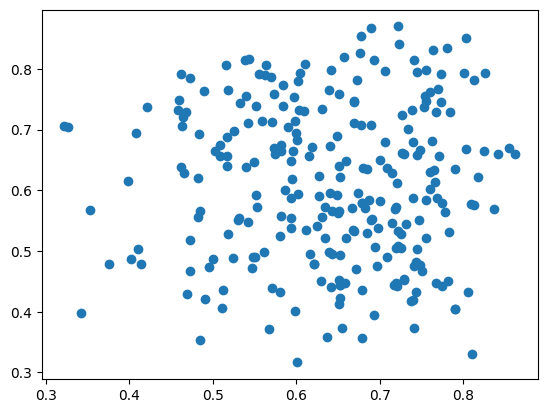

In [ ]:
plt.scatter(similarity_scores_256, similarity_scores_512)

## Visualizing learned embeddings

In [ ]:
!pip install panphon

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 4.1 MB/s eta 0:00:00
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10744 sha256=c63463722d9150913ea5ebf5004329729642ccbd537d65b0ac2027a26f9b4f17
  Stored in directory: /root/.cache/pip/wheels/f2/67/7d/2e80818c2f3dc8f0735d0810338c47e95d3212114ab97b4ede
Successfully built unicodecsv


In [ ]:
import panphon
import numpy as np

In [ ]:
ft = panphon.featuretable.FeatureTable()
def ipa_to_vec(ipa):
  fv = ft.word_to_vector_list(ipa, numeric = True)
  return np.array(fv)
vecs_sid = []
for ipa in cleaned_siddham_ipa:
  vec = ipa_to_vec(ipa)
  vecs_sid.append(vec)
len(vecs_sid)

vecs_han_1 = []
for ipa in cleaned_pinyin_list_256:
  vec = ipa_to_vec(ipa)
  vecs_han_1.append(vec)
len(vecs_han_1)

vecs_han_2 = []
for ipa in cleaned_pinyin_list_512:
  vec = ipa_to_vec(ipa)
  vecs_han_2.append(vec)
len(vecs_han_2)

261

In [ ]:
len_sid = []
for sid in vecs_sid:
  len_sid.append(len(sid))
len_han_1 = []
for han in vecs_han_1:
  len_han_1.append(len(han))
len_han_2 = []
for han in vecs_han_2:
  len_han_2.append(len(han))

### Visualzing the stretching and/or compressibility of rhythm in Hanzi

In [ ]:
def rhythmic_sim(len_arr_s, len_arr_h):
  return 0.5 ** abs(len_arr_s - len_arr_h)

In [ ]:
rhythmic_sim_256 = [rhythmic_sim(s, h) for s, h in zip(len_sid, len_han_1)]
rhythmic_sim_512 = [rhythmic_sim(s, h) for s, h in zip(len_sid, len_han_2)]

Text(0.5, 1.0, 'Segmental rhythm preservation comparison')

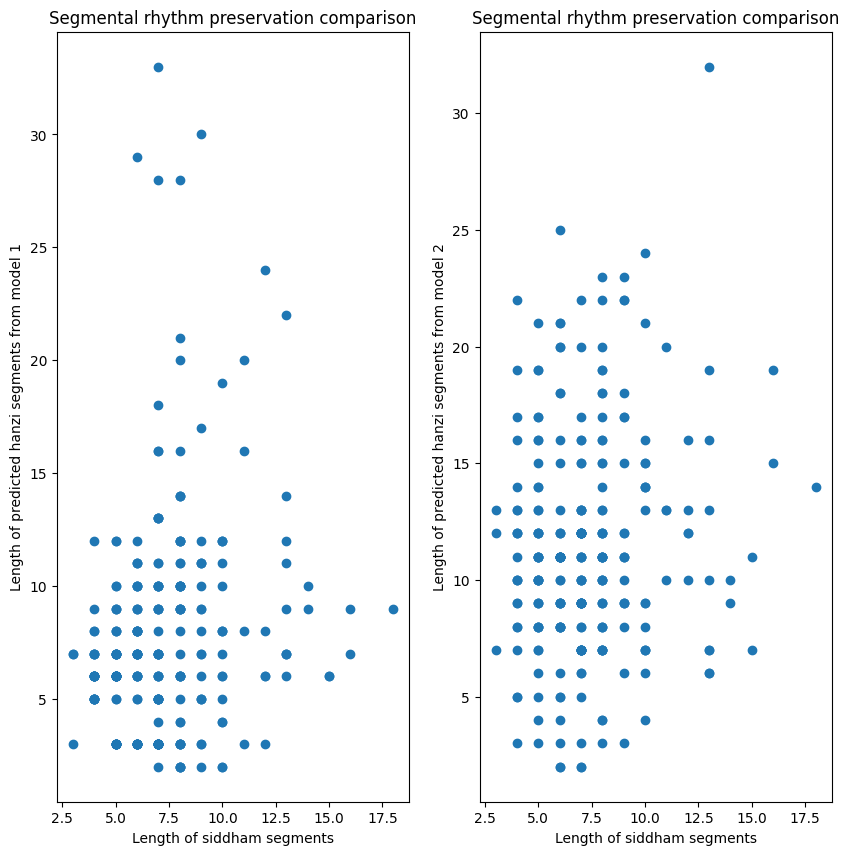

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.scatter(len_sid, len_han_1)
ax1.set_xlabel("Length of siddham segments")
ax1.set_ylabel("Length of predicted hanzi segments from model 1")
ax1.set_title("Segmental rhythm preservation comparison")

ax2.scatter(len_sid, len_han_2)
ax2.set_xlabel("Length of siddham segments")
ax2.set_ylabel("Length of predicted hanzi segments from model 2")
ax2.set_title("Segmental rhythm preservation comparison")

In [ ]:
from scipy.spatial.distance import cosine
import numpy as np

def mean_cosine_similarity(vec_s, vec_h):
    L = min(len(vec_s), len(vec_h))
    if L == 0:
        return np.nan
    # normalize each feature vector
    vec_s_n = vec_s[:L] / np.linalg.norm(vec_s[:L], axis=1, keepdims=True)
    vec_h_n = vec_h[:L] / np.linalg.norm(vec_h[:L], axis=1, keepdims=True)
    sims = [1 - cosine(vec_s_n[i], vec_h_n[i]) for i in range(L)]
    return np.mean(sims)

phonetic_sim_256 = [mean_cosine_similarity(s, h) for s, h in zip(vecs_sid, vecs_han_1)]
phonetic_sim_512 = [mean_cosine_similarity(s, h) for s, h in zip(vecs_sid, vecs_han_2)]

In [ ]:
phonetic_sim_256[:10], phonetic_sim_512[:10]

([np.float64(0.36387588098805407),
  np.float64(0.48420425898637254),
  np.float64(0.4545092893617123),
  np.float64(0.4068864604554684),
  np.float64(0.3703808473151355),
  np.float64(0.4107810540013383),
  np.float64(0.42035370477253586),
  np.float64(0.4281116824721822),
  np.float64(0.46296556615045503),
  np.float64(0.3480418809270682)],
 [np.float64(0.5287423819747892),
  np.float64(0.5017942662812258),
  np.float64(0.5474856691154407),
  np.float64(0.49908940319840195),
  np.float64(0.4646790633739268),
  np.float64(0.4002586486528177),
  np.float64(0.2964100579151503),
  np.float64(0.6110433503546575),
  np.float64(0.6498561860264556),
  np.float64(0.4380734578520923)])

Text(0.5, 1.0, 'Rhtyhmic vs Phonetic scores for model 2')

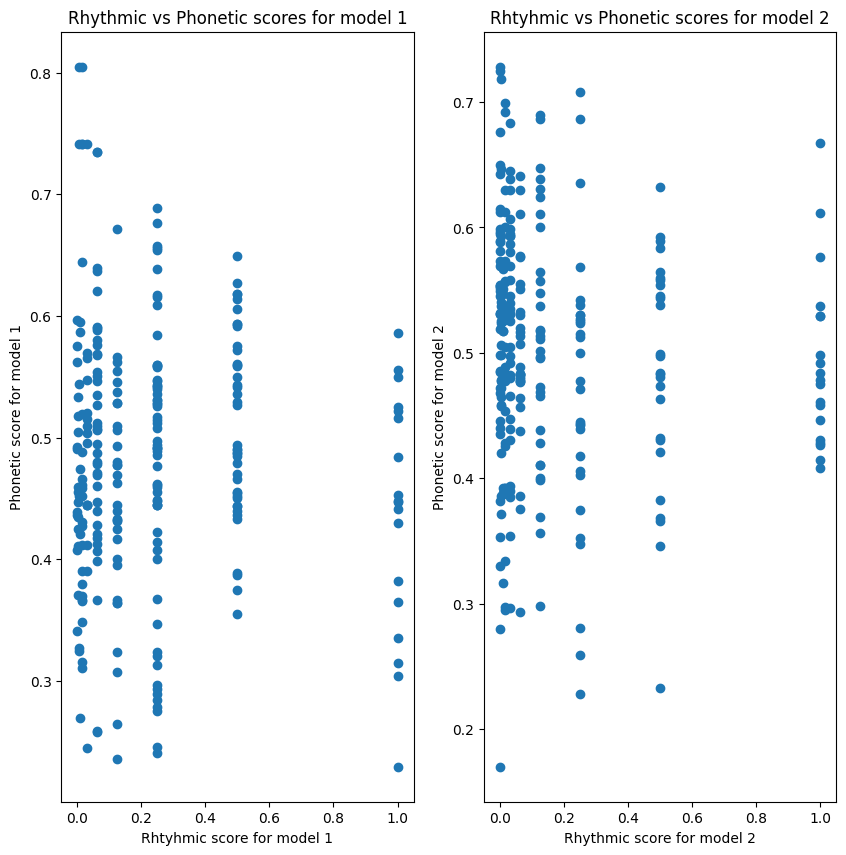

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.scatter(rhythmic_sim_256, phonetic_sim_256)
ax1.set_xlabel("Rhtyhmic score for model 1")
ax1.set_ylabel("Phonetic score for model 1")
ax1.set_title("Rhythmic vs Phonetic scores for model 1")
ax2.scatter(rhythmic_sim_512, phonetic_sim_512)
ax2.set_xlabel("Rhythmic score for model 2")
ax2.set_ylabel("Phonetic score for model 2")
ax2.set_title("Rhtyhmic vs Phonetic scores for model 2")

In [ ]:
## Composite fidelity index
comp_score_256 = [p ** 0.7 * r ** 0.3 for (p,r) in zip(phonetic_sim_256, rhythmic_sim_256)]
comp_score_512 = []

[np.float64(0.2640829075049973),
 np.float64(0.6018940131792799),
 np.float64(0.4677038404073956),
 np.float64(0.23195047817327946),
 np.float64(0.07678439669732483),
 np.float64(0.08255555381038981),
 np.float64(0.12716494995645236),
 np.float64(0.240355442549804),
 np.float64(0.3125770495354549),
 np.float64(0.1371791358555532),
 np.float64(0.34735469603594105),
 np.float64(0.4011894391190247),
 np.float64(0.24332830889457335),
 np.float64(0.35796198087997066),
 np.float64(0.300852974264439),
 np.float64(0.30113716212486835),
 np.float64(0.5720025286651913),
 np.float64(0.5340968885783782),
 np.float64(0.5493657534606404),
 np.float64(0.5415790431753564),
 np.float64(0.28678700846914107),
 np.float64(0.2005190108047081),
 np.float64(0.5097842057233647),
 np.float64(0.2188991709674154),
 np.float64(0.43226657059945156),
 np.float64(0.35062322847371663),
 np.float64(0.3172656543394381),
 np.float64(0.2696337254595749),
 np.float64(0.29789981136296284),
 np.float64(0.2237471890993546),


In [ ]:
statistics.mean(comp_score_256)

np.float64(0.3289996993159274)

In [ ]:
alpha, beta = 0.7, 0.3
comp_score_hmean = [1 / (alpha / p + beta / r) for (p, r) in zip(phonetic_sim_256, rhythmic_sim_256)]
statistics.mean(comp_score_hmean)

np.float64(0.2728191925534605)

In [ ]:
alpha, beta = 0.7, 0.3
comp_score_linear = [alpha * p + beta * r for (p, r) in zip(phonetic_sim_256, rhythmic_sim_256)]
statistics.mean(comp_score_linear)

np.float64(0.4090655394480826)

In [ ]:
lambda_r = 0.4
R_smooth_1 = [1 - (1 - r) ** lambda_r for r in rhythmic_sim_256]
from sklearn.preprocessing import MinMaxScaler
import numpy as np

C_scaled_1 = MinMaxScaler().fit_transform(np.array(phonetic_sim_256).reshape(-1, 1)).flatten()
R_scaled_1 = MinMaxScaler().fit_transform(np.array(R_smooth_1).reshape(-1, 1)).flatten()

import numpy as np
alpha, beta, delta = 0.7, 0.3, 0.5
comp_score_logistic_256 = 1 / (1 + np.exp(-((alpha * C_scaled_1 + beta * R_scaled_1) - delta)))

R_smooth_2 = [1 - (1 - r) ** lambda_r for r in rhythmic_sim_512]
C_scaled_2 = MinMaxScaler().fit_transform(np.array(phonetic_sim_512).reshape(-1, 1)).flatten()
R_scaled_2 = MinMaxScaler().fit_transform(np.array(R_smooth_2).reshape(-1, 1)).flatten()
comp_score_logistic_512 = 1 / (1 + np.exp(-((alpha * C_scaled_2 + beta * R_scaled_2) - delta)))

statistics.mean(comp_score_logistic_256), statistics.mean(comp_score_logistic_512)

(np.float64(0.46303573267660414), np.float64(0.48812862671424506))